# Calculate Ridge Metrics

This notebook contains the code required to calculate ridge metrics from the previously created datasets:
- Ridges
- Migration Pathways
- Packets
- Ridge Area Raster
- DEM

From these datasets, we will calculate ridge width, amplitude, and migration distance at every ridge-transect intersection and aggregate/summarize these measurements at the intersection, ridge, transect, packet, and bend scales. 


In [70]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import LineString
import numpy as np

from scrollstats import calculate_ridge_metrics

## Set input/output paths

In [99]:
# Vector Datasets
ridge_path = Path("example_data/input/LBR_025_ridges_manual_smoothed.geojson")
transect_path = Path("example_data/output/LBR_025_transects.geojson")
packet_path = Path("example_data/input/LBR_025_packets.geojson")
centerline_path = Path("example_data/input/LBR_025_cl.geojson") # only needed for plotting

# Raster Datasets
bin_path = Path("example_data/output/LBR_025_agr_denoise500px80p.tif")
dem_path = Path("example_data/input/LBR_025_dem.tif")

# Output
output_dir = Path("example_data/output")


## Read in datasets from input paths

In [100]:
# Vector Data
ridges = gpd.read_file("example_data/input/test_ridges.geojson")
transects = gpd.read_file(transect_path)
packets = gpd.read_file(packet_path)
cl = gpd.read_file(centerline_path)

# Raster Data
bin_raster = rasterio.open(bin_path)
dem = rasterio.open(dem_path)


## Calculate Metrics

## Calculate the ridge metrics

The `calculate_ridge_metrics` function takes the transects, ridges, clipped ridge area (binary) and DEM rasters as input and returns two GeoDataFrames
- `rich transects`
- `itx points`

The `rich_transects` retain the same geometry as the input transects but have the following additional fields:
- `r_000` ... `r_###`: the distance between the channel centerline and that ridge along the specified transect
- `dem_signal`: dem values sampled along the transect with 1m sampling 
- `bin_signal`: binary raster values sampled along the transect with 1m sampling
- `clean_bin_signal`:
- `ridge_count_raster`: the ridge count along the transect calcualted from the number of unique ridges in `bin_signal`
- `fft_spacing`: the fft-derived dominant wavelength from `bin_signal` - corresponds to a representative spacing between ridges along the transect

The `itx` points are the collection of point intersections between the ridges and transects. `itx` contains the following fields:
- `start_distances`
- `transect_position`: vertex position of the intersection point along the transect
- `metric_confidence`: a simple metric derived from `bin_signal` describing the confidence in other ridge metrics.
- `relative_vertex_distances`: the relative along-transect distance of the substring that corresponds to the intersection. A relative vertex position of 0.5 is at the exact midpoint of the transect.
- `vertex_indices`: the indicies of the `dem_signal` or `binary_signal` of the transect that correspond to the location of the itx substring
- `dem_signal`: the section of the transect's `dem_signal` that corresponds to the itx substring
- `dem_signal_selection`: ukn
- `bin_signal`: the section of the transect's `bin_signal` that corresponds to the itx substring
- `bool_mask`: ukn
- `pre_mig_dist`: the migration distance from the previous ridge 
- `post_mig_dist`: the migration distance to the next ridge
- `pre_mig_time`: the difference in `deposit_year` between the intersected and previous ridge
- `post_mig_time`: the difference in `deposit_year` between the intersected and next ridge
- `pre_mig_rate`: `pre_mig_dist` / `pre_mig_time`
- `post_mig_rate`: `post_mig_dist` / `post_mig_time`
- `ridge_width`: the width of the ridge derived from `bin_signal` measured in px
- `ridge_amp`: the amplitude of the ridge derived from `dem_signal` measured in units of the DEM
- `deposit_year`: `deposit_year` of the corresponding ridge
- `substring_geometry`: the `LineString` of the substring corresponding to the intersection
- `geometry`: the `Point` geometry of the intersection
- `swale_dq_adjustment`: ukn



In [101]:
rich_transects, itx = calculate_ridge_metrics(transects, bin_raster, dem, ridges)
itx = itx.loc["LBR_025"]

Started BDE
Started TDE for t_006
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_007
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_008
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_009
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_010
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_011
Started RDE
Started RDE
Started RDE
Started TDE for t_012
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_013
Started RDE
Started TDE for t_014
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_015
Started RDE
Started RDE
Started RDE
Started RDE
Started TDE for t_016
Started RDE
St

In [102]:
# Add packets
itx_w_packets = itx.sjoin(packets.drop("bend_id", axis=1))
itx_w_packets = itx_w_packets.reset_index().set_index(["transect_id", "ridge_id", "packet_id"])
ridge_metrics_w_packets = itx_w_packets[["ridge_amp", "ridge_width", "pre_mig_dist"]]
ridge_metrics_w_packets.columns = ridge_metrics_w_packets.columns.rename("metrics")

In [103]:
itx_w_packets.head()

start_distances  transect_position  \
transect_id ridge_id packet_id                                       
t_006       r_002    p_04            208.232323                  4   
            r_018    p_04            118.064974                  1   
            r_019    p_04              0.000000                  0   
            r_020    p_04            144.589842                  2   
            r_021    p_04            163.493560                  3   

                                metric_confidence  \
transect_id ridge_id packet_id                      
t_006       r_002    p_04                       4   
            r_018    p_04                       3   
            r_019    p_04                       3   
            r_020    p_04                       3   
            r_021    p_04                       4   

                                                        relative_vertex_distances  \
transect_id ridge_id packet_id                                                      
t_006       r_002    p_04       [0.4598869086007843, 0.5851511088480504, 0.778...   
            r_018    p_04       [0.2607497979447568, 0.3193307096275627, 0.361...   
            r_019    p_04           [0.0, 0.2607497979447568, 0.3193307096275627]   
            r_020    p_04       [0.3193307096275627, 0.36108009980543077, 0.45...   
            r_021    p_04       [0.36108009980543077, 0.4598869086007843, 0.58...   

                                 vertex_indices  \
transect_id ridge_id packet_id                    
t_006       r_002    p_04       [208, 265, 353]   
            r_018    p_04       [118, 145, 164]   
            r_019    p_04         [0, 118, 145]   
            r_020    p_04       [145, 164, 208]   
            r_021    p_04       [164, 208, 265]   

                                                                       dem_signal  \
transect_id ridge_id packet_id                                                      
t_006       r_002    p_04       [67.77913665771484, 67.77913665771484, 67.7264...   
            r_018    p_04       [66.09736633300781, 66.1637954711914, 66.27700...   
            r_019    p_04       [60.16259765625, 60.162532806396484, 60.163047...   
            r_020    p_04       [68.7772216796875, 68.80960083007812, 68.75959...   
            r_021    p_04       [68.31321716308594, 68.2929458618164, 68.29294...   

                                                             dem_signal_selection  \
transect_id ridge_id packet_id                                                      
t_006       r_002    p_04       [67.77913665771484, 67.77913665771484, 67.7264...   
            r_018    p_04       [66.09736633300781, 66.1637954711914, 66.27700...   
            r_019    p_04       [64.69462585449219, 64.69462585449219, 64.8953...   
            r_020    p_04       [68.7772216796875, 68.80960083007812, 68.75959...   
            r_021    p_04       [68.31321716308594, 68.2929458618164, 68.29294...   

                                                                       bin_signal  \
transect_id ridge_id packet_id                                                      
t_006       r_002    p_04       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_018    p_04       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_019    p_04       [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
            r_020    p_04       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_021    p_04       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...   

                                                                        bool_mask  \
transect_id ridge_id packet_id                                                      
t_006       r_002    p_04       [True, True, True, True, True, True, True, Tru...   
            r_018    p_04       [True, True, True, True, True, True, True, Tru...   
            r_019    p_04       [True, True, True, True, True, True, True, Tru...   
  

Text(0.5, 1.0, 'Ridge amplitude at each intersection')

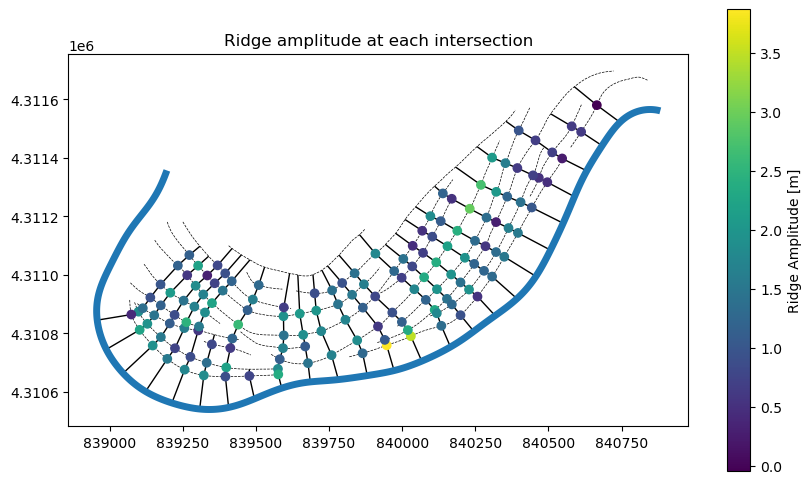

In [104]:
# Plot itx
fig, ax = plt.subplots(1,1, figsize=(10,6))
ridges.plot(ax=ax, color="k", ls="--", lw=0.5, zorder=0)
transects.plot(ax=ax, color="k", lw=1, zorder=1)
cl.plot(ax=ax, color="tab:blue", lw=5, zorder=2)

itx_w_packets.plot(column="ridge_amp", ax=ax, zorder=2, legend=True, 
                   legend_kwds={"label": "Ridge Amplitude [m]"})

ax.set_title("Ridge amplitude at each intersection")
